#0 Preparations

Installing required packages


In [ ]:
!pip install -r requirements.txt

Import required packages

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import string
import warnings


from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sqlalchemy import create_engine

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 1 Connect to SQL DB and download data

Init function to load large amount of data from sql db

In [ ]:
def batch_load_sql(query: str, engine) -> pd.DataFrame:
    CHUNKSIZE = 200000
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)

Create connection and download data from sql db

In [ ]:
engine = create_engine('###')

#SQL query to download first 10 rows for each user
sql_query = "select * from (select public.feed_data.*, row_number() over (partition by user_id order by random() desc) i from public.feed_data) t where i <= 10 and action='view'"

user_data = pd.read_sql('SELECT * FROM public.user_data', con=engine)

post_text_df = pd.read_sql('SELECT * FROM public.post_text_df', con=engine)

feed_data = batch_load_sql(sql_query, engine=engine)

In [ ]:
user_data

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads
...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic
163201,168549,0,18,Russia,Tula,2,Android,organic
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic
163203,168551,0,38,Russia,Moscow,3,iOS,organic


In [ ]:
post_text_df

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7019,7316,I give this movie 2 stars purely because of it...,movie
7020,7317,I cant believe this film was allowed to be mad...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie


In [ ]:
feed_data

,timestamp,user_id,post_id,action,target,i
0,2021-12-13 08:33:12,200,6919,view,1,2
1,2021-12-24 13:58:06,200,6396,view,0,3
2,2021-11-30 09:21:28,200,3663,view,0,4
3,2021-10-06 15:09:25,200,3868,view,0,5
4,2021-11-30 09:41:28,200,1644,view,0,6
...,...,...,...,...,...,...
1461015,2021-11-07 06:29:48,168552,778,view,0,6
1461016,2021-10-12 12:45:40,168552,5392,view,0,7
1461017,2021-12-20 18:48:01,168552,6548,view,0,8
1461018,2021-10-12 13:17:29,168552,6588,view,0,9


Download additional features for users from sql db

In [ ]:
#like rate information
sql_query = """
SELECT user_id, COUNT(target) FILTER (WHERE target = 1) / COUNT(target) FILTER (WHERE target = 0)::DECIMAL AS like_rate
FROM public.feed_data
GROUP BY user_id
"""

user_data = pd.merge(
    user_data,
    pd.read_sql(sql_query, con=engine),
    on='user_id',
    how='left'
)

#day of week with most likes
sql_query = """
WITH likes_count_t AS (
SELECT user_id, EXTRACT('isodow' FROM "timestamp") dow, COUNT(target) as likes_count
FROM public.feed_data fa
WHERE target = 1
GROUP BY user_id, EXTRACT('isodow' FROM "timestamp"))

SELECT DISTINCT ON (user_id) user_id, dow, likes_count
FROM likes_count_t
WHERE (user_id, likes_count) IN (SELECT user_id, MAX(likes_count) AS max_count
FROM likes_count_t
GROUP BY user_id)
"""

user_data = pd.merge(
    user_data,
    pd.read_sql(sql_query, con=engine).drop('likes_count',axis=1),
    on='user_id',
    how='left'
)

#the average number of characters on the user's favorite topic
sql_query = """
WITH likes_count_t AS (
SELECT user_id, topic, COUNT(target) as likes_count
FROM public.feed_data fa
JOIN post p on fa.post_id = p.id
WHERE target = 1
GROUP BY user_id, topic)

SELECT DISTINCT ON (user_id) user_id, t1.topic, likes_count, avg_chars
FROM likes_count_t
JOIN (SELECT topic, AVG(LENGTH(text)) as avg_chars
FROM post
GROUP BY topic) t1 on t1.topic=likes_count_t.topic
WHERE (user_id, likes_count) IN (SELECT user_id, MAX(likes_count) AS max_count
FROM likes_count_t
GROUP BY user_id)
"""

user_data = pd.merge(
    user_data,
    pd.read_sql(sql_query, con=engine).drop(['likes_count','topic'],axis=1),
    on='user_id',
    how='left'
)

#unloved user topic
sql_query = """
WITH likes_count_t AS (
SELECT user_id, topic, COUNT(target) as likes_count
FROM public.feed_data fa
JOIN post p on fa.post_id = p.id
WHERE target=1
GROUP BY user_id, topic)

SELECT DISTINCT ON (user_id) user_id, topic, likes_count
FROM likes_count_t
WHERE (user_id, likes_count) IN (SELECT user_id, MIN(likes_count) AS min_count
FROM likes_count_t
GROUP BY user_id)
"""

user_data = pd.merge(
    user_data,
    pd.read_sql(sql_query, con=engine).drop('likes_count',axis=1),
    on='user_id',
    how='left'
)

#average user likes per day
sql_query = """
SELECT user_id, AVG(likes_count)
FROM (SELECT user_id, DATE(timestamp), COUNT(target) as likes_count
FROM public.feed_data fa
WHERE target = 1
GROUP BY user_id, DATE(timestamp)) t1
GROUP BY user_id
"""

user_data = pd.merge(
    user_data,
    pd.read_sql(sql_query, con=engine),
    on='user_id',
    how='left'
)

#user last week like activity
sql_query = """
SELECT user_id, COUNT(target) AS likes_count_from_last_week
FROM public.feed_data
WHERE target=1 AND timestamp BETWEEN (SELECT MAX(timestamp) - INTERVAL '7 days' FROM public.feed_data) AND (SELECT MAX(timestamp) FROM public.feed_data)
GROUP BY user_id
"""

user_data = pd.merge(
    user_data,
    pd.read_sql(sql_query, con=engine),
    on='user_id',
    how='left'
)

#user last month like activity
sql_query = """
SELECT user_id, COUNT(target) AS likes_count_from_last_month
FROM public.feed_data
WHERE action = 'like' AND timestamp BETWEEN (SELECT MAX(timestamp) - INTERVAL '1 month' FROM public.feed_data) AND (SELECT MAX(timestamp) FROM public.feed_data)
GROUP BY user_id
"""

user_data = pd.merge(
    user_data,
    pd.read_sql(sql_query, con=engine),
    on='user_id',
    how='left'
)

In [ ]:
user_data

,user_id,gender,age,country,city,exp_group,os,source,like_rate,dow,avg_chars,topic,avg,likes_count_from_last_week,likes_count_from_last_month
0,200,1,34,Russia,Degtyarsk,3,Android,ads,0.120112,2.0,1266.548333,business,3.307692,6.0,16.0
1,201,0,37,Russia,Abakan,0,Android,ads,0.084058,3.0,1266.548333,politics,2.761905,4.0,25.0
2,202,1,17,Russia,Smolensk,4,Android,ads,0.136578,2.0,1266.548333,business,3.782609,8.0,22.0
3,203,0,18,Russia,Moscow,1,iOS,ads,0.190031,5.0,1266.548333,entertainment,5.545455,NaN,23.0
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads,0.166667,3.0,1266.548333,tech,4.600000,6.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic,0.055249,5.0,1266.548333,business,1.818182,NaN,7.0
163201,168549,0,18,Russia,Tula,2,Android,organic,0.087302,3.0,2662.388489,sport,2.750000,1.0,5.0
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic,0.102981,6.0,1266.548333,sport,2.923077,NaN,16.0
163203,168551,0,38,Russia,Moscow,3,iOS,organic,0.100629,1.0,1266.548333,tech,2.823529,5.0,21.0


Rename new features

In [ ]:
user_data = user_data.rename(columns={"dow": "most_active_dow", "avg_chars": "fav_topic_avg_chars", "topic" : "not_fav_topic", "avg" : "avg_actions_per_day"})

In [ ]:
user_data

,user_id,gender,age,country,city,exp_group,os,source,like_rate,most_active_dow,fav_topic_avg_chars,not_fav_topic,avg_actions_per_day,likes_count_from_last_week,likes_count_from_last_month
0,200,1,34,Russia,Degtyarsk,3,Android,ads,0.120112,2.0,1266.548333,business,3.307692,6.0,16.0
1,201,0,37,Russia,Abakan,0,Android,ads,0.084058,3.0,1266.548333,politics,2.761905,4.0,25.0
2,202,1,17,Russia,Smolensk,4,Android,ads,0.136578,2.0,1266.548333,business,3.782609,8.0,22.0
3,203,0,18,Russia,Moscow,1,iOS,ads,0.190031,5.0,1266.548333,entertainment,5.545455,NaN,23.0
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads,0.166667,3.0,1266.548333,tech,4.600000,6.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic,0.055249,5.0,1266.548333,business,1.818182,NaN,7.0
163201,168549,0,18,Russia,Tula,2,Android,organic,0.087302,3.0,2662.388489,sport,2.750000,1.0,5.0
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic,0.102981,6.0,1266.548333,sport,2.923077,NaN,16.0
163203,168551,0,38,Russia,Moscow,3,iOS,organic,0.100629,1.0,1266.548333,tech,2.823529,5.0,21.0


# 2 Prepare user_data dataframe

Check the data for NA values

In [ ]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163205 entries, 0 to 163204
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   user_id                      163205 non-null  int64  
 1   gender                       163205 non-null  int64  
 2   age                          163205 non-null  int64  
 3   country                      163205 non-null  object 
 4   city                         163205 non-null  object 
 5   exp_group                    163205 non-null  int64  
 6   os                           163205 non-null  object 
 7   source                       163205 non-null  object 
 8   like_rate                    163205 non-null  float64
 9   most_active_dow              163202 non-null  float64
 10  fav_topic_avg_chars          163202 non-null  float64
 11  not_fav_topic                163202 non-null  object 
 12  avg_actions_per_day          163202 non-null  float64
 13 

Fill NA values

In [ ]:
popular_category = user_data['not_fav_topic'].value_counts().index[0]
user_data['not_fav_topic'] = user_data['not_fav_topic'].fillna(popular_category)

mean_avg_chars = user_data['fav_topic_avg_chars'].mean()
median_most_active_dow = user_data['most_active_dow'].median()
mean_avg_actions_per_day = user_data['avg_actions_per_day'].mean()
mean_likes_count_lw = user_data['likes_count_from_last_week'].mean()
mean_likes_count_lm = user_data['likes_count_from_last_month'].mean()

user_data['fav_topic_avg_chars'] = user_data['fav_topic_avg_chars'].fillna(mean_avg_chars)
user_data['most_active_dow'] = user_data['most_active_dow'].fillna(median_most_active_dow)
user_data['avg_actions_per_day'] = user_data['avg_actions_per_day'].fillna(mean_avg_actions_per_day)
user_data['likes_count_from_last_week'] = user_data['likes_count_from_last_week'].fillna(mean_likes_count_lw)
user_data['likes_count_from_last_month'] = user_data['likes_count_from_last_month'].fillna(mean_likes_count_lm)

Check the data numeric columns distribution

In [ ]:
num_columns = ['like_rate', 'fav_topic_avg_chars', 'avg_actions_per_day', 'likes_count_from_last_week','likes_count_from_last_month']

Text(0.5, 0.98, 'Histograms of various features')

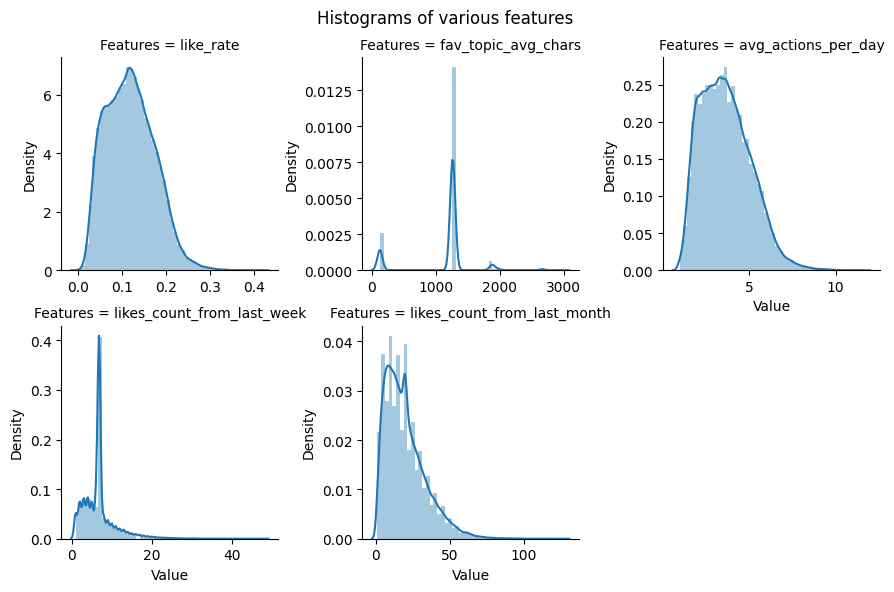

In [ ]:
numeric_features = user_data[num_columns]

numeric_features = numeric_features.stack().reset_index().rename(
    columns={'level_1': 'Features', 0: 'Value'})

ax = sns.FacetGrid(data=numeric_features, col='Features', col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, 'Value')

plt.subplots_adjust(top=0.9)
plt.suptitle('Histograms of various features')

Normalize the distribution

In [ ]:
for i in ['like_rate', 'avg_actions_per_day', 'likes_count_from_last_week', 'likes_count_from_last_month']:
  user_data[i] = np.log(user_data[i]+1)

Text(0.5, 0.98, 'Histograms of various features')

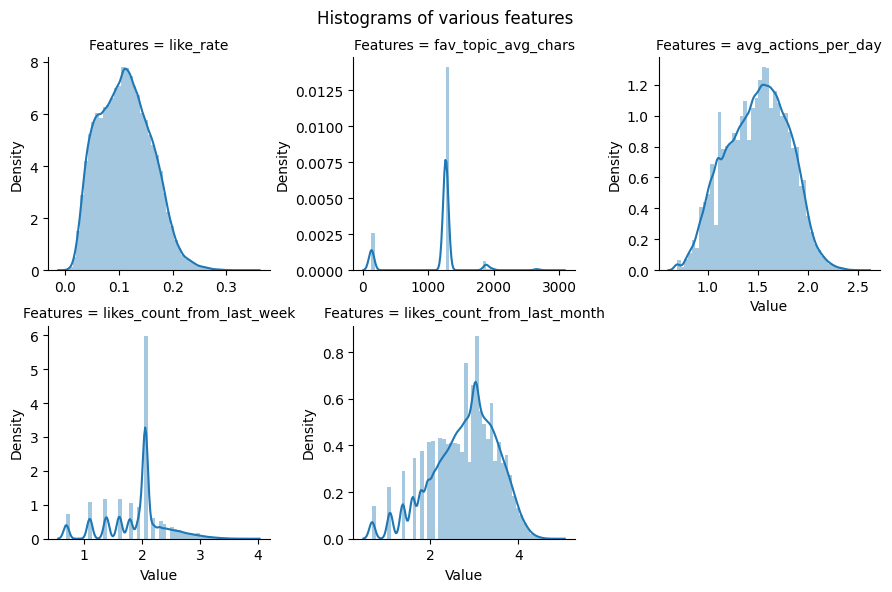

In [ ]:
numeric_features = user_data[num_columns]

numeric_features = numeric_features.stack().reset_index().rename(
    columns={'level_1': 'Features', 0: 'Value'})

ax = sns.FacetGrid(data=numeric_features, col='Features', col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, 'Value')

plt.subplots_adjust(top=0.9)
plt.suptitle('Histograms of various features')

In [ ]:
user_data = user_data.astype({"most_active_dow": int})

In [ ]:
user_data

,user_id,gender,age,country,city,exp_group,os,source,like_rate,most_active_dow,fav_topic_avg_chars,not_fav_topic,avg_actions_per_day,likes_count_from_last_week,likes_count_from_last_month
0,200,1,34,Russia,Degtyarsk,3,Android,ads,0.113428,2,1266.548333,business,1.460402,1.945910,2.833213
1,201,0,37,Russia,Abakan,0,Android,ads,0.080711,3,1266.548333,politics,1.324925,1.609438,3.258097
2,202,1,17,Russia,Smolensk,4,Android,ads,0.128022,2,1266.548333,business,1.564986,2.197225,3.135494
3,203,0,18,Russia,Moscow,1,iOS,ads,0.173979,5,1266.548333,entertainment,1.878771,2.055887,3.178054
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads,0.154151,3,1266.548333,tech,1.722767,1.945910,2.890372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic,0.053776,5,1266.548333,business,1.036092,2.055887,2.079442
163201,168549,0,18,Russia,Tula,2,Android,organic,0.083699,3,2662.388489,sport,1.321756,0.693147,1.791759
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic,0.098017,6,1266.548333,sport,1.366876,2.055887,2.833213
163203,168551,0,38,Russia,Moscow,3,iOS,organic,0.095882,1,1266.548333,tech,1.341174,1.791759,3.091042


In [ ]:
user_data.to_sql('a_cherepaschuk_user_features_v2_lesson_22', con=engine, if_exists='replace') # write table

205

# 3 Text preprocessing and TF-IDF

Init data cleaning and lemmatize tokenizer and make TF-IDF vector

In [ ]:
snowball = WordNetLemmatizer()
english_stop_words = stopwords.words("english")

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language="english")
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in english_stop_words]
    tokens = [snowball.lemmatize(i) for i in tokens]
    return tokens

vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

features = vectorizer.fit_transform(post_text_df['text']).toarray()


In [ ]:
features = pd.DataFrame(
    features,
    index=post_text_df['post_id'],
    columns=vectorizer.get_feature_names_out()
)
features.head()

,"+10,219",+14,+214,"+3,328","+36,128",+429,+44,"+48,472",+49,"+5,297",...,🤬,🤭,🤲👍,🦠,🦠now,🦠🇮🇳,🦠🦠…,🧙🏼‍♀️,🧼wash,🩸
post_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Extract new features from TF-IDF vector

In [ ]:
post_info = post_text_df.copy()
post_info['total_tf_idf'] = features.sum(axis=1).reset_index()[0]
post_info['max_tf_idf'] = features.max(axis=1).reset_index()[0]
post_info['mean_tf_idf'] = features.mean(axis=1).reset_index()[0]

Reduce dimesionality of TF-IDF with PCA

In [ ]:
centered = features - features.mean()
pca = PCA(n_components=50)
pca_data = pca.fit_transform(centered)

Get features

In [ ]:
pca_columns = ["PCA_"+str(i) for i in range(1,51)]

pca_data = pd.DataFrame(data=pca_data, columns=pca_columns)
pca_data

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49,PCA_50
0,-0.091272,0.155120,-0.043872,-0.105417,-0.124384,-0.211695,-0.093210,0.018123,-0.170849,-0.010902,...,0.020961,0.041222,0.010920,-0.014491,-0.010196,0.000123,-0.018955,-0.024093,-0.013645,-0.011982
1,-0.085483,0.188298,0.052697,0.016779,-0.030277,-0.041054,0.013635,-0.007882,-0.014203,-0.002171,...,0.063693,-0.005706,-0.010424,0.040041,-0.062551,-0.052580,-0.032216,0.010333,-0.015459,-0.016841
2,-0.071080,0.111950,-0.048972,-0.103776,-0.124782,-0.159151,-0.085255,0.008771,-0.032538,-0.002536,...,-0.024571,-0.028309,-0.012311,0.047429,-0.034986,-0.016136,-0.044921,-0.013322,0.005142,0.092897
3,-0.087481,0.080478,-0.020576,-0.063637,-0.097027,-0.075081,-0.033446,-0.010122,0.045416,-0.010396,...,0.030935,-0.027660,-0.008791,0.026325,0.014289,0.061796,-0.039012,-0.073191,0.007792,0.024907
4,-0.061835,0.049885,-0.018426,-0.036756,-0.036833,-0.027564,0.006057,0.010667,0.060414,0.004325,...,-0.041513,-0.017469,-0.011492,-0.011256,-0.001795,-0.023163,-0.037076,-0.012168,0.003339,-0.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,0.184275,-0.034388,0.124960,-0.074027,-0.000970,0.001787,0.006652,0.003783,-0.007632,-0.007007,...,0.027981,0.036273,-0.034738,0.005712,0.013859,0.020565,0.022076,0.008895,-0.022830,-0.051998
7019,0.151259,-0.029902,0.079653,-0.044432,-0.022141,-0.002322,0.019447,-0.014731,-0.018294,0.003830,...,-0.012834,-0.015408,-0.017218,-0.005832,0.012558,0.017837,0.034113,-0.028277,0.019413,0.018729
7020,0.073582,-0.024775,-0.078047,0.100996,-0.020579,0.009540,-0.034385,-0.027844,0.002220,0.004745,...,0.016020,0.005136,-0.023585,-0.011041,-0.022882,0.006115,0.018471,0.023948,0.001122,-0.010783
7021,0.075233,-0.001864,-0.072270,0.079246,-0.019496,0.001356,-0.003953,-0.007717,-0.005141,0.003862,...,0.022681,0.009437,-0.030993,0.012110,-0.021073,-0.037538,0.027388,-0.046101,-0.012292,0.031761


# 4 Prepare final dataset

In [ ]:
post_info = pd.concat((post_info, pca_data), axis=1)
post_info

,post_id,text,topic,total_tf_idf,max_tf_idf,mean_tf_idf,PCA_1,PCA_2,PCA_3,PCA_4,...,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49,PCA_50
0,1,UK economy facing major risks\n\nThe UK manufa...,business,9.412852,0.477866,0.000158,-0.091272,0.155120,-0.043872,-0.105417,...,0.020961,0.041222,0.010920,-0.014491,-0.010196,0.000123,-0.018955,-0.024093,-0.013645,-0.011982
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,12.846987,0.245499,0.000216,-0.085483,0.188298,0.052697,0.016779,...,0.063693,-0.005706,-0.010424,0.040041,-0.062551,-0.052580,-0.032216,0.010333,-0.015459,-0.016841
2,3,Asian quake hits European shares\n\nShares in ...,business,13.383601,0.256425,0.000225,-0.071080,0.111950,-0.048972,-0.103776,...,-0.024571,-0.028309,-0.012311,0.047429,-0.034986,-0.016136,-0.044921,-0.013322,0.005142,0.092897
3,4,India power shares jump on debut\n\nShares in ...,business,6.707371,0.529312,0.000113,-0.087481,0.080478,-0.020576,-0.063637,...,0.030935,-0.027660,-0.008791,0.026325,0.014289,0.061796,-0.039012,-0.073191,0.007792,0.024907
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.478985,0.412921,0.000109,-0.061835,0.049885,-0.018426,-0.036756,...,-0.041513,-0.017469,-0.011492,-0.011256,-0.001795,-0.023163,-0.037076,-0.012168,0.003339,-0.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,7.208761,0.257277,0.000121,0.184275,-0.034388,0.124960,-0.074027,...,0.027981,0.036273,-0.034738,0.005712,0.013859,0.020565,0.022076,0.008895,-0.022830,-0.051998
7019,7316,I give this movie 2 stars purely because of it...,movie,7.262576,0.365120,0.000122,0.151259,-0.029902,0.079653,-0.044432,...,-0.012834,-0.015408,-0.017218,-0.005832,0.012558,0.017837,0.034113,-0.028277,0.019413,0.018729
7020,7317,I cant believe this film was allowed to be mad...,movie,6.146129,0.538860,0.000103,0.073582,-0.024775,-0.078047,0.100996,...,0.016020,0.005136,-0.023585,-0.011041,-0.022882,0.006115,0.018471,0.023948,0.001122,-0.010783
7021,7318,The version I saw of this film was the Blockbu...,movie,7.470195,0.219498,0.000125,0.075233,-0.001864,-0.072270,0.079246,...,0.022681,0.009437,-0.030993,0.012110,-0.021073,-0.037538,0.027388,-0.046101,-0.012292,0.031761


In [ ]:
post_info.to_sql('a_cherepaschuk_post_features_v2_main_lesson_22', con=engine, if_exists='replace') # write table

23

Extract features from timestamp

In [ ]:
feed_data['timestamp'] = pd.to_datetime(feed_data['timestamp'])

feed_data['hour'] = feed_data['timestamp'].apply(lambda x: x.hour)
feed_data['month'] = feed_data['timestamp'].apply(lambda x: x.month)

In [ ]:
final_dataset = pd.merge(feed_data, post_info, how='left', on='post_id')
final_dataset.head(5)

,timestamp,user_id,post_id,action,target,i,hour,month,text,topic,...,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49,PCA_50
0,2021-12-13 08:33:12,200,6919,view,1,2,8,12,Methinks the best screen version of Quo Vadis?...,movie,...,0.006044,-0.014871,0.003574,-0.040151,-0.013403,-0.001636,0.038390,0.018845,0.041632,-0.009174
1,2021-12-24 13:58:06,200,6396,view,0,3,13,12,The original story and funny compelling charac...,movie,...,0.035842,-0.005331,-0.022537,0.016825,0.005311,0.002456,0.001672,0.000101,-0.106925,-0.015600
2,2021-11-30 09:21:28,200,3663,view,0,4,9,11,Highest single day recovery for the third cons...,covid,...,0.019343,0.016371,0.000386,0.008757,-0.023191,0.024794,0.010817,-0.079185,-0.021868,-0.015942
3,2021-10-06 15:09:25,200,3868,view,0,5,15,10,@muychael @mhdksafa Its my belief we are only ...,covid,...,-0.006595,-0.000859,0.014541,-0.020082,0.017489,-0.015767,-0.015026,0.003086,-0.005046,-0.022366
4,2021-11-30 09:41:28,200,1644,view,0,6,9,11,Dogged Federer claims Dubai crown\n\nWorld num...,sport,...,0.049372,-0.017924,0.032059,0.035477,-0.014487,-0.005226,-0.011714,-0.024958,-0.016123,0.014372


In [ ]:
final_dataset = pd.merge(final_dataset, user_data, how='left', on='user_id')
final_dataset.head(5)

,timestamp,user_id,post_id,action,target,i,hour,month,text,topic,...,exp_group,os,source,like_rate,most_active_dow,fav_topic_avg_chars,not_fav_topic,avg_actions_per_day,likes_count_from_last_week,likes_count_from_last_month
0,2021-12-13 08:33:12,200,6919,view,1,2,8,12,Methinks the best screen version of Quo Vadis?...,movie,...,3,Android,ads,0.113428,2,1266.548333,business,1.460402,1.94591,2.833213
1,2021-12-24 13:58:06,200,6396,view,0,3,13,12,The original story and funny compelling charac...,movie,...,3,Android,ads,0.113428,2,1266.548333,business,1.460402,1.94591,2.833213
2,2021-11-30 09:21:28,200,3663,view,0,4,9,11,Highest single day recovery for the third cons...,covid,...,3,Android,ads,0.113428,2,1266.548333,business,1.460402,1.94591,2.833213
3,2021-10-06 15:09:25,200,3868,view,0,5,15,10,@muychael @mhdksafa Its my belief we are only ...,covid,...,3,Android,ads,0.113428,2,1266.548333,business,1.460402,1.94591,2.833213
4,2021-11-30 09:41:28,200,1644,view,0,6,9,11,Dogged Federer claims Dubai crown\n\nWorld num...,sport,...,3,Android,ads,0.113428,2,1266.548333,business,1.460402,1.94591,2.833213


In [ ]:
final_dataset = final_dataset.drop(['text', 'action', 'i'], axis=1)

In [ ]:
final_dataset = final_dataset.set_index(['user_id', 'post_id'])

#5 Model training

Prepare train and test data

In [ ]:
max(final_dataset.timestamp), min(final_dataset.timestamp)

(Timestamp('2021-12-29 23:48:26'), Timestamp('2021-10-01 06:02:00'))

In [ ]:
X_train = final_dataset[final_dataset['timestamp'] < '2021-12-15'].drop(['timestamp','target'], axis=1)
X_test = final_dataset[final_dataset['timestamp'] >= '2021-12-15'].drop(['timestamp','target'], axis=1)

y_train = final_dataset[final_dataset['timestamp'] < '2021-12-15']['target']
y_test = final_dataset[final_dataset['timestamp'] >= '2021-12-15']['target']

In [ ]:
object_columns = [
    'topic', 'country', 'city', 'os',
    'source', 'not_fav_topic', 'hour', 'month', 'gender','most_active_dow', 'exp_group'
]

Train default catboost model

In [ ]:
base_model = CatBoostClassifier()
base_model.fit(X_train, y_train, object_columns)

Learning rate set to 0.214038
0:	learn: 0.5368271	total: 3.86s	remaining: 1h 4m 19s
1:	learn: 0.4523070	total: 9.32s	remaining: 1h 17m 30s
2:	learn: 0.4063904	total: 14.5s	remaining: 1h 20m 4s
3:	learn: 0.3784350	total: 16.1s	remaining: 1h 6m 43s
4:	learn: 0.3614556	total: 18.6s	remaining: 1h 1m 50s
5:	learn: 0.3528048	total: 21.4s	remaining: 59m 9s
6:	learn: 0.3475345	total: 23.5s	remaining: 55m 34s
7:	learn: 0.3438830	total: 27.4s	remaining: 56m 41s
8:	learn: 0.3412008	total: 31.8s	remaining: 58m 26s
9:	learn: 0.3393330	total: 34.5s	remaining: 56m 53s
10:	learn: 0.3380453	total: 37.3s	remaining: 55m 49s
11:	learn: 0.3360356	total: 39.9s	remaining: 54m 44s
12:	learn: 0.3352858	total: 43.8s	remaining: 55m 22s
13:	learn: 0.3347932	total: 48.1s	remaining: 56m 28s
14:	learn: 0.3345086	total: 52.3s	remaining: 57m 11s
15:	learn: 0.3335497	total: 55.1s	remaining: 56m 28s
16:	learn: 0.3331815	total: 58.2s	remaining: 56m 5s
17:	learn: 0.3327301	total: 1m	remaining: 55m 25s
18:	learn: 0.3321295

In [ ]:
print(f'ROC-AUC on train: {roc_auc_score(y_train, base_model.predict_proba(X_train)[:, 1])}')
print(f'ROC_AUC on test: {roc_auc_score(y_test, base_model.predict_proba(X_test)[:, 1])}')

print(f'Accuracy on train: {accuracy_score(y_train, base_model.predict(X_train))}')
print(f'Accuracy on test: {accuracy_score(y_test, base_model.predict(X_test))}')


ROC-AUC on train: 0.7476467440359311
ROC_AUC on test: 0.6907417027159827
Accuracy on train: 0.8875932138816223
Accuracy on test: 0.8639736428624312


In [ ]:
base_model.save_model('kc_project_rec_system_cb_model_v5',
                           format="cbm")

Feature importance

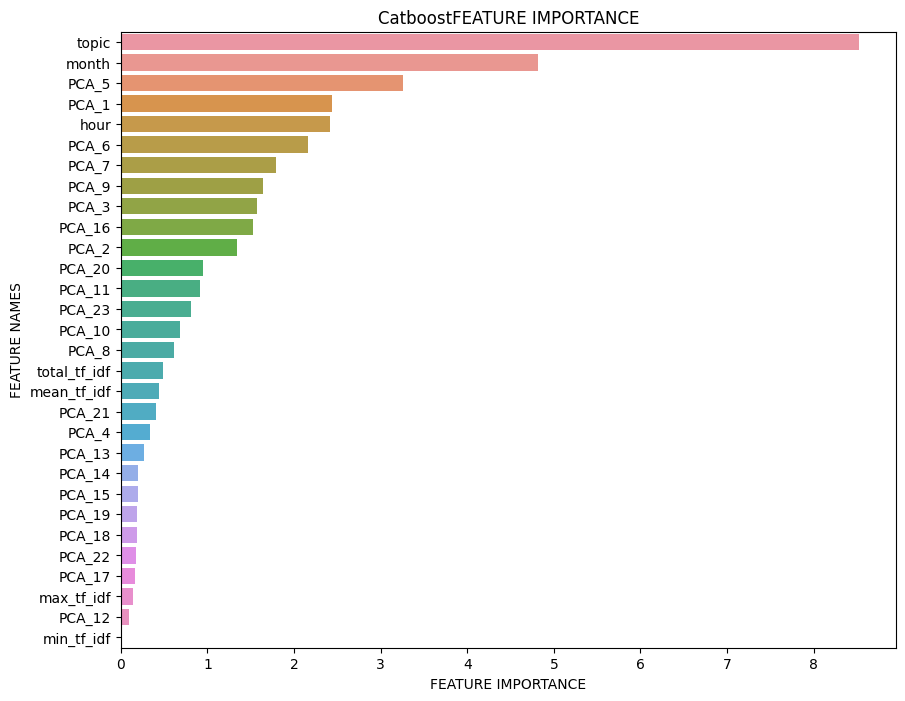

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)[:30]
    feature_names = np.array(names)[:30]

    data = {'feature_importance': feature_importance,
           'feature_names': feature_names}

    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by='feature_importance', ascending=False, inplace=True)

    plt.figure(figsize=(10, 8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(base_model.feature_importances_, X_train.columns, 'Catboost')